# Neural Network: General Model

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

from datetime import datetime
#from pycorrcat.pycorrcat import corr_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf 

from pyspark.sql.functions import *
from pyspark.sql.types import *

import joblib

import shap
pd.set_option('display.max_rows', 200)

#### Data Paths'

In [2]:
df = pd.read_csv("C:\\Users\\aureliano.paiva\\Downloads\\classificacao_Q2.csv")

In [3]:
df.target.value_counts()

1    1258
0    1242
Name: target, dtype: int64

In [4]:
# Getting the data:
X = df.drop(['target'], axis = 1)

y = df['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25, stratify = y)

In [6]:
#var_num = ['total_balance', 'idade_da_divida', 'soma_total_enviado']
#StdSca = MinMaxScaler() ## or standerscaler 
#X_train[var_num] = pd.DataFrame(StdSca.fit_transform(X_train[var_num]), columns = var_num, index = X_train.index)
#X_test[var_num] = pd.DataFrame(StdSca.transform(X_test[var_num]), columns = var_num, index = X_test.index)
# df[var_num] = StdSca.transform(df[var_num])

In [7]:
CCW = compute_class_weight('balanced',y = y, classes = np.unique(y))

In [8]:
CCW = compute_class_weight('balanced',y = y, classes = np.unique(y))
weights = {0: CCW[0], 1: CCW[1]}

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CVO = list(skf.split(X_train, y_train))

In [10]:
def create_nn(n_neurons=20):
    
    model = tf.keras.models.Sequential([ 
                                        tf.keras.layers.Dense(n_neurons, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
                                        ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.FalsePositives(),
                            tf.keras.metrics.FalseNegatives(),
                            tf.keras.metrics.TruePositives(),
                            tf.keras.metrics.TrueNegatives(),
                            ])

    return model

In [11]:
EPOCHS  = 5
NEURONS = len(X.columns)

results = {}
for ifold, (trn_idx, val_idx) in enumerate(CVO):
    if ifold == 0:
        results['fold_%i' %(ifold+1)] = {}
        print('-> processing fold: %i' %(ifold+1))

        # define the data to use in training
        trn_data = X_train.iloc[trn_idx]
        trn_y    = y_train.iloc[trn_idx]
        val_data = X_train.iloc[val_idx]
        val_y    = y_train.iloc[val_idx]
        l_x_test = X_test.copy()

        # create a model
        l_model = create_nn(n_neurons=20)
        loss_monitor = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, verbose=0, 
                                                        mode="auto", baseline=None, restore_best_weights=True)

        results['fold_%i' %(ifold+1)]['train_history'] = l_model.fit(x=trn_data, y=trn_y, class_weight= weights,
                                                                     validation_data=(val_data, val_y),
                                                                     epochs=EPOCHS, batch_size=1024, verbose=2, callbacks=[loss_monitor]).history

        # collect information
        results['fold_%i' %(ifold+1)]['tst_measure']  = l_model.evaluate(x=l_x_test, 
                                                                         y=y_test,
                                                                         return_dict=True)

        results['fold_%i' %(ifold+1)]['trn_measure']  = l_model.evaluate(x=trn_data, 
                                                                         y=trn_y, 
                                                                         return_dict=True)

        results['fold_%i' %(ifold+1)]['val_measure']  = l_model.evaluate(x=val_data, 
                                                                         y=val_y, 
                                                                         return_dict=True)

        all_data = pd.concat([trn_data, val_data, l_x_test], ignore_index=True)
        all_y    = pd.concat([trn_y, val_y, y_test], ignore_index=True)

        results['fold_%i' %(ifold+1)]['ope_measure']  = l_model.evaluate(x=all_data, 
                                                                         y=all_y, 
                                                                         return_dict=True)

        results['fold_%i' %(ifold+1)]['model'] = l_model.get_weights()
        print('-> saving trained model')
        #l_model.save('../../notebooks/Modelo_geral_entrega/Geral-nn-model_fold%i' %(ifold))


    else: 
        pass

-> processing fold: 1
Epoch 1/5
2/2 - 5s - loss: 0.8614 - auc: 0.6321 - recall: 0.9828 - precision: 0.5171 - false_positives: 693.0000 - false_negatives: 13.0000 - true_positives: 742.0000 - true_negatives: 52.0000 - val_loss: 0.8523 - val_auc: 0.6468 - val_recall: 0.9787 - val_precision: 0.5140 - val_false_positives: 174.0000 - val_false_negatives: 4.0000 - val_true_positives: 184.0000 - val_true_negatives: 13.0000
Epoch 2/5
2/2 - 0s - loss: 0.8219 - auc: 0.6524 - recall: 0.9815 - precision: 0.5189 - false_positives: 687.0000 - false_negatives: 14.0000 - true_positives: 741.0000 - true_negatives: 58.0000 - val_loss: 0.8164 - val_auc: 0.6651 - val_recall: 0.9681 - val_precision: 0.5141 - val_false_positives: 172.0000 - val_false_negatives: 6.0000 - val_true_positives: 182.0000 - val_true_negatives: 15.0000
Epoch 3/5
2/2 - 0s - loss: 0.7842 - auc: 0.6745 - recall: 0.9748 - precision: 0.5201 - false_positives: 679.0000 - false_negatives: 19.0000 - true_positives: 736.0000 - true_negative

## Avaliação

In [12]:
meu_modelo = l_model

In [13]:
X_train['nn_output'] = meu_modelo.predict(X_train)
X_test['nn_output'] = meu_modelo.predict(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


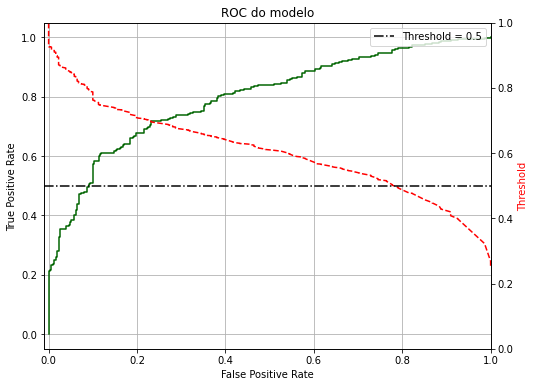

In [14]:
#define metrics
fpr, tpr, sarrafo = roc_curve(y_test,  X_test['nn_output'])
sarrafo = sarrafo[fpr <= 1]

#create ROC curve
plt.figure(figsize = (8,6))
plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
plt.grid()
plt.title(f"ROC do modelo")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
ax2 = plt.gca().twinx()
ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([0,1])
ax2.set_xlim([-0.01,1])
ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
plt.legend()

plt.show()

### Histograma

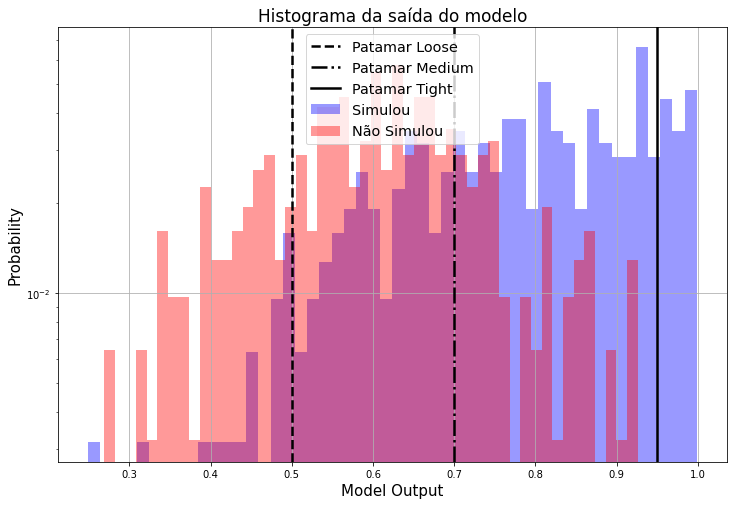

In [15]:
#Figura
plt.figure(figsize = (12,8))
# weights for hist 1
weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "nn_output"].values)/\
              len(X_test.loc[y_test == 1, "nn_output"]))
# weights for hist 2
weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "nn_output"].values)/\
              len(X_test.loc[y_test != 1, "nn_output"]))

plt.hist(X_test.loc[y_test == 1, "nn_output"], 
         label='Simulou', weights=weights_h1,
         color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
plt.hist(X_test.loc[y_test != 1, "nn_output"], 
         label='Não Simulou', weights=weights_h2, 
         color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
#sns.histplot(x = x_test["probabilidade de pagar"],
#             hue = y_test)
plt.ylabel('Probability', fontsize=15)
plt.xlabel('Model Output', fontsize=15)
plt.grid()
plt.title(f"Histograma da saída do modelo", fontsize=17) 
plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
plt.legend(loc='upper center', fontsize='x-large')
plt.yscale('log')
plt.show()

## Matrizes segundo limiar.

In [16]:
CV = meu_modelo


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


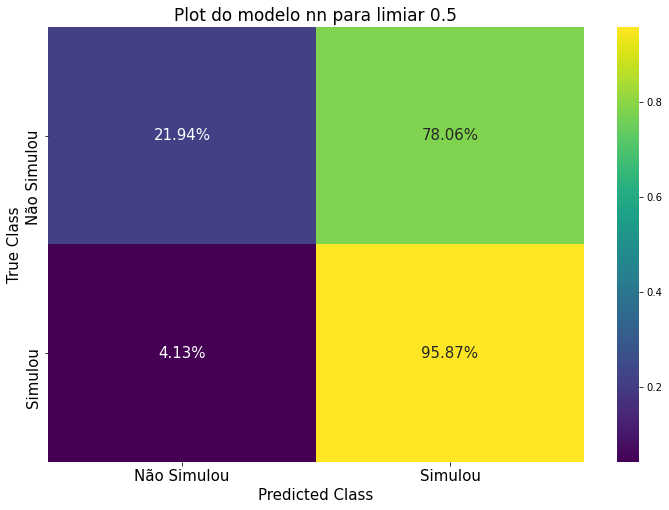

'/n'

In [17]:
X_test["prediction"] = 0
X_test.loc[X_test.nn_output > 0.5, "prediction"] = 1

plt.figure(figsize = (12,8))
matriz = confusion_matrix(y_test, X_test['prediction'], normalize = "true")
ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
ax.set_title(f"Plot do modelo nn para limiar 0.5", fontsize=17)
ax.set_ylabel("True Class", fontsize=15)
ax.set_xlabel("Predicted Class", fontsize=15)
ax.set_xticklabels(["Não Simulou", "Simulou"], fontsize=15)
ax.set_yticklabels(["Não Simulou", "Simulou"], fontsize=15)
plt.show()
"/n"


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


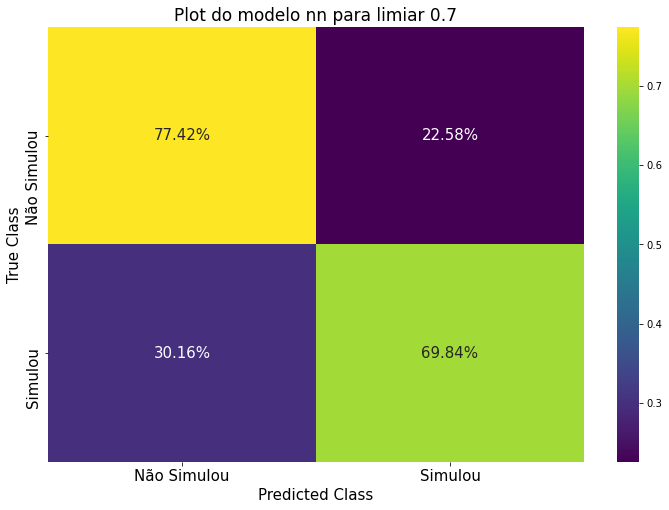

In [18]:
X_test["prediction"] = 0
X_test.loc[X_test.nn_output > 0.7, "prediction"] = 1

plt.figure(figsize = (12,8))
matriz = confusion_matrix(y_test, X_test['prediction'], normalize = "true")
ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
ax.set_title(f"Plot do modelo nn para limiar 0.7", fontsize=17)
ax.set_ylabel("True Class", fontsize=15)
ax.set_xlabel("Predicted Class", fontsize=15)
ax.set_xticklabels(["Não Simulou", "Simulou"], fontsize=15)
ax.set_yticklabels(["Não Simulou", "Simulou"], fontsize=15)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


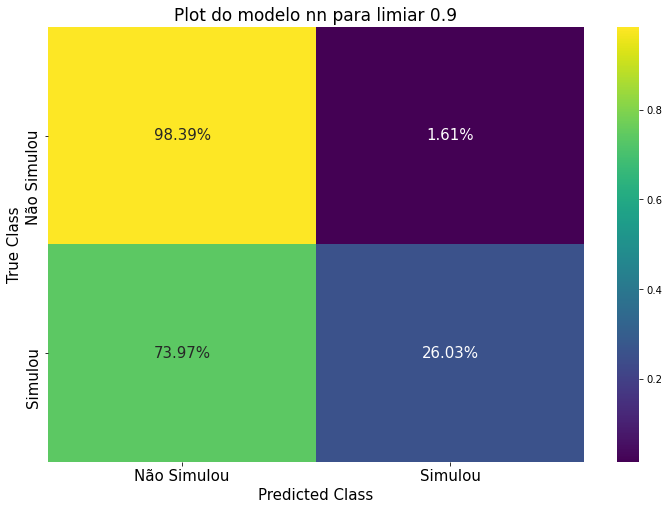

In [19]:
X_test["prediction"] = 0
X_test.loc[X_test.nn_output > 0.9, "prediction"] = 1

plt.figure(figsize = (12,8))
matriz = confusion_matrix(y_test, X_test['prediction'], normalize = "true")
ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
ax.set_title(f"Plot do modelo nn para limiar 0.9", fontsize=17)
ax.set_ylabel("True Class", fontsize=15)
ax.set_xlabel("Predicted Class", fontsize=15)
ax.set_xticklabels(["Não Simulou", "Simulou"], fontsize=15)
ax.set_yticklabels(["Não Simulou", "Simulou"], fontsize=15)
plt.show()

In [20]:
X_test["prediction"] = 0
X_test.loc[X_test.nn_output > 0.5, "prediction"] = 1

print(classification_report(y_test, X_test.prediction))

              precision    recall  f1-score   support

           0       0.84      0.22      0.35       310
           1       0.56      0.96      0.70       315

    accuracy                           0.59       625
   macro avg       0.70      0.59      0.53       625
weighted avg       0.70      0.59      0.53       625




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
X_train.drop("nn_output", axis = 1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
meu_modelo.evaluate(X_train, y_train, batch_size=2048, return_dict=True)

1/1 [==============================] - 0s 39ms/step - loss: 0.6944 - auc: 0.7422 - recall: 0.9565 - precision: 0.5337 - false_positives: 788.0000 - false_negatives: 41.0000 - true_positives: 902.0000 - true_negatives: 144.0000


{'loss': 0.6944146752357483,
 'auc': 0.7421734929084778,
 'recall': 0.95652174949646,
 'precision': 0.5337278246879578,
 'false_positives': 788.0,
 'false_negatives': 41.0,
 'true_positives': 902.0,
 'true_negatives': 144.0}

In [23]:
X_test.drop(['nn_output', 'prediction'], axis = 1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
modelo = meu_modelo
colunas = X_test.columns
X100 = shap.utils.sample(X_test, 2000)

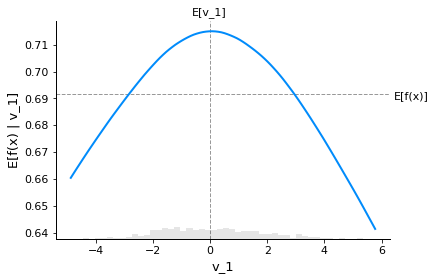

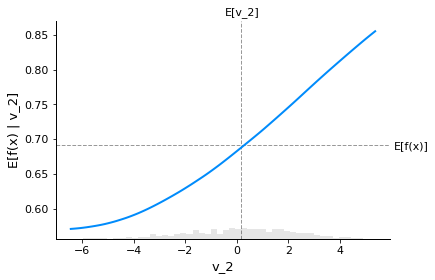

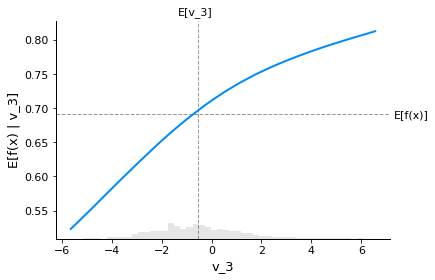

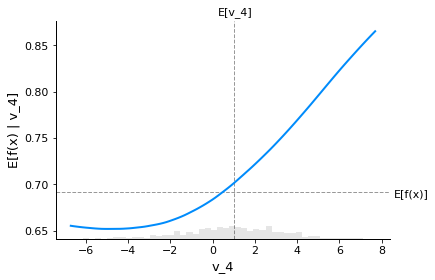

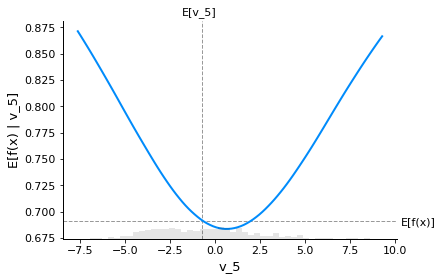

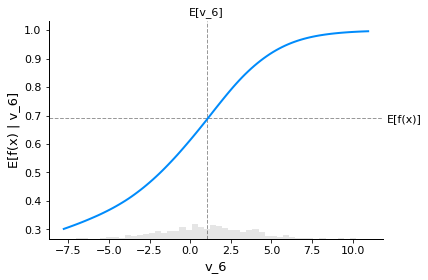

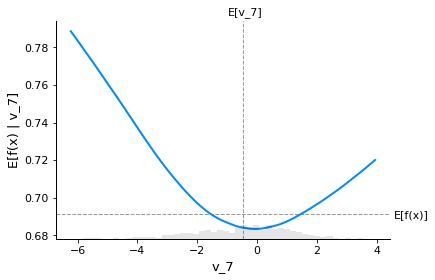

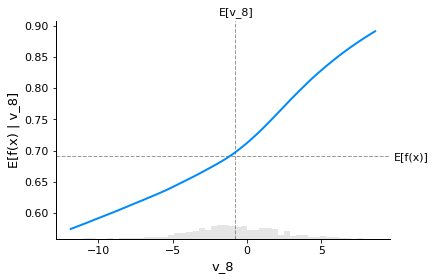

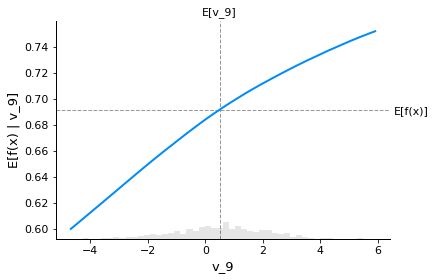

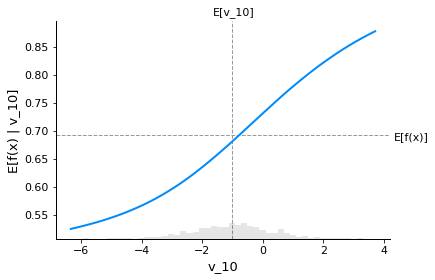

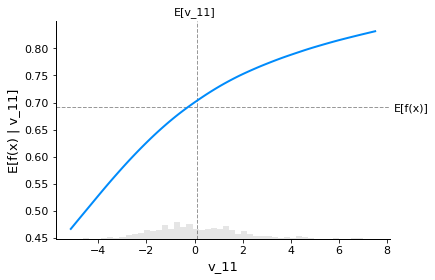

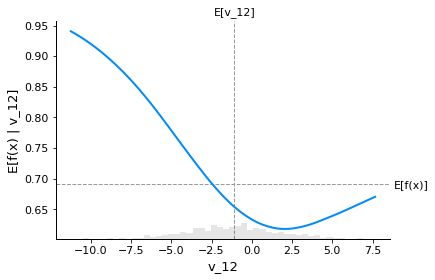

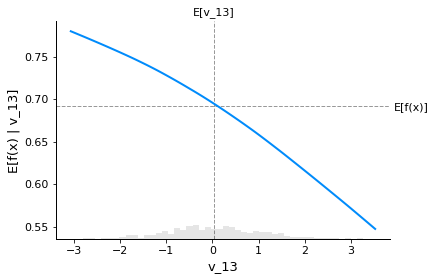

In [25]:
for icol in colunas:
    shap.plots.partial_dependence(
        icol, modelo.predict, X100, ice=False,
        model_expected_value=True, feature_expected_value=True
    )